<h1> Credit Card Fraud Detection Model and EDA with Simple ML Algorithms</h1>

## a. Install all the dependencies

In [1]:
!pip install -r requirements1.txt

## b. Import all the required Libraries and Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score,roc_curve,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split,cross_val_predict
import matplotlib.pyplot as plt
import pickle

## c. Pull the LFS elements (CSV file)

In [4]:
#Install git lfs if absent

In [5]:
# Pull the LFS from git 
!git lfs pull

## d. Read the Credit Card CSV file

In [6]:
# Read the dataset
data = pd.read_csv("creditcard.csv")

### Dataset Info

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# e. Data Analysis

### e.1 Removing Unwanted Columns

In [8]:
# Removing the time column since it would not help in model training
data.drop(["Time"],axis=1,inplace = True)

### e.2 Checking for Null Values

In [9]:
# Lets check the missing values in case any
data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### e.3 Correlation of columns w.r.t. every column

In [10]:
def plot_corr(df):
    corr = df.corr()
    fig,ax = plt.subplots(figsize = (12,12))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show()

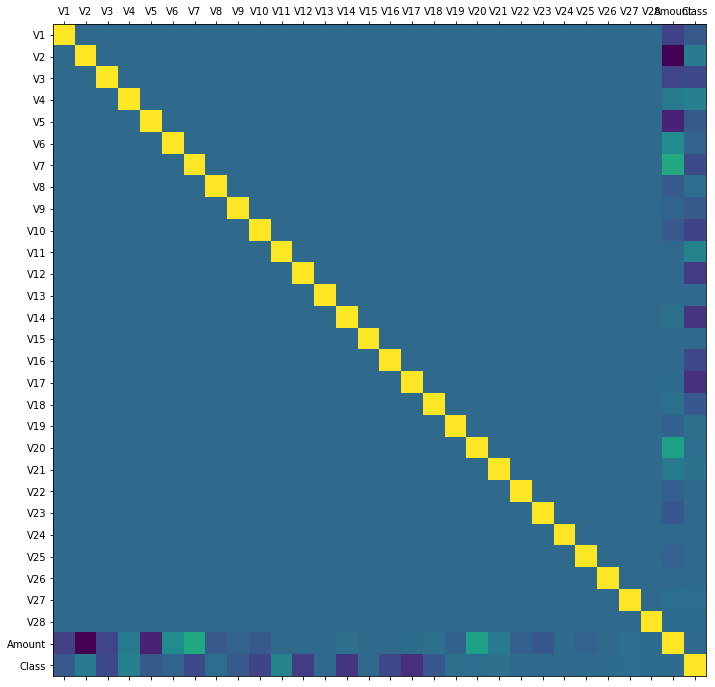

In [11]:
# Vizualizing correletaions by plotting correlation matrix
plot_corr(data)


### e.4 Correlation elements w.r.t the target Column

In [12]:
corr = data.corr()
corr["Class"]

V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

### e.5 Removing highy negative and highly Positive Correlated Columns

In [13]:
# These are features either are too negatively correlated with the target or too much positive with target(may surpress other features)

COL=["V3","V10","V12","V14","V16","V17","V18"]
data.drop(COL,axis=1,inplace=True)

### e.6 Scalling the values for better modelling (Normalizing)

In [14]:
# Lets normalise the amount column
# Need not to perform scaling of other features since all values have been scaled because of the PCA applied before the data was released

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Amount'],axis=1)

### e.7 Checking Class Distribution

In [16]:
# Checking the ratio of classes with respect to each other 
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### e.8 Equalizing the Class Distribution to avoid creating Skewed class model

In [17]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# Equalizing no. of Fraud rows data with no of Non-Fraud data rows (492 rows each as in the dataset).
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

# Concating equal no of Fraud data and Non-Fraud Data into a new dataframe
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V4,V5,V6,V7,V8,V9,V11,V13,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
95135,-3.752122,3.047004,1.134186,-1.673215,1.591196,-2.213236,3.194713,0.193793,-1.250883,1.445510,...,-0.301557,-0.705405,0.033526,-1.328491,0.527516,-0.272297,0.231970,0.072393,0,-0.317127
247995,1.146259,1.403458,2.660107,-0.323217,-1.836071,-1.623740,0.259562,-1.132044,3.646478,-0.647501,...,0.564450,0.445744,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,1,-0.147848
245088,-1.769102,-0.571667,-0.628063,0.004222,-0.329594,-0.066065,0.681990,0.293276,-1.720258,-1.380995,...,0.358729,0.345879,0.145703,0.469233,-0.036766,0.653551,0.139899,-0.014254,0,0.278468
279863,-1.927883,1.125653,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,2.115795,-1.235123,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1,1.206024
15506,-21.885434,12.930505,6.203314,-16.466099,-4.459842,-16.519836,14.535565,-3.897022,5.375434,0.461808,...,1.762232,-1.579055,-0.951043,0.134565,1.507110,-0.222671,1.527655,0.453699,1,0.046539


### e.9 Splitting the data (Features and Target) into Training and Testing sets

In [18]:
# Lets split the data into features (X) and target (Y)
features = new_df.drop(["Class"],axis =1)
target = new_df["Class"]


# Splitting the data into train and test
X_train,X_test, Y_train,Y_test = train_test_split(features, target, test_size = .2, random_state =5)

<h1> f. GRID SEARCH CV </h1>
Lets apply the grid search in order to obtain the best hyperparamters for our models

In [19]:
class GridSearchModel:
    def __init__(self):
        print("GridSearchModel Class Initialized\n\n")
        
    def fit_log_reg(self,params,X,Y):
        """Logistic Regression"""
        grid_log_reg = GridSearchCV(LogisticRegression(),params)
        grid_log_reg.fit(X,Y)
        # Logistic Regression with the best parameters
        grid_log_reg_best_est = grid_log_reg.best_estimator_
        print("{}\n".format(grid_log_reg_best_est))
        return grid_log_reg_best_est
    
    def fit_knn(self,params,X,Y):
        """K-Nearest Neighbors"""
        grid_knears = GridSearchCV(KNeighborsClassifier(),params)
        grid_knears.fit(X,Y)
        # KNears best estimator
        grid_knears_best_est = grid_knears.best_estimator_
        print("{}\n".format(grid_knears_best_est))
        return grid_knears_best_est

    def fit_svc(self,params,X,Y):
        """Support Vector Classifier"""
        grid_svc = GridSearchCV(SVC(), params)
        grid_svc.fit(X,Y)
        # SVC best estimator
        grid_svc_best_est = grid_svc.best_estimator_
        print("{}\n".format(grid_svc_best_est))
        return grid_svc_best_est


    def fit_dec_tree(self,params,X,Y):
        """Decision Tree Classifier"""
        grid_tree = GridSearchCV(DecisionTreeClassifier(), params)
        grid_tree.fit(X,Y)
        # Decision Tree best estimator
        grid_tree_best_est = grid_tree.best_estimator_
        print("{}\n".format(grid_tree_best_est))
        return grid_tree_best_est

<h1> g. Fitting Grid Search on our models </h1>

In [21]:
#Instance of GridSearchModel
gridModel = GridSearchModel()

"""Logistic Regression"""
# Solver is liblinear since its supports both l1 and l2 penalities
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],"solver" :['liblinear']}
log_reg_best_est = gridModel.fit_log_reg(log_reg_params,X_train,Y_train)


"""K-Nearest Neighbors"""
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knears_best_est = gridModel.fit_knn(knears_params,X_train,Y_train)


"""Support Vector Classifier"""
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
svc_best_est = gridModel.fit_svc(svc_params,X_train,Y_train)


"""DecisionTree Classifier"""
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),"min_samples_leaf": list(range(5,7,1))}
dec_tree_best_est = gridModel.fit_dec_tree(tree_params,X_train,Y_train)

GridSearchModel Class Initialized


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrea

<h1>h. Initializing K-Fold for training our models</h1>
We would be utilizing cross validation score in order to get a much better result

In [22]:
# Initializing K-Fold for training all specified models
k = KFold(n_splits = 5)

# Specified Classifiers
classifiers = {
    'Logistic Regression':log_reg_best_est,
    'Support Vector Machine' : svc_best_est,
    'Random Forest Classifier': RandomForestClassifier(),
    'Decision Tree Algorithm':dec_tree_best_est,
    'KNN':knears_best_est
}

<h1>i. Model Class with utilities </h1>

In [25]:
class ML_Models:
    def __init__(self):
        print("Initialized ML_Models class\n\n")

    def train(self,classifiers,train_data =(X_train,Y_train),val_data=(X_test,Y_test)):
        for i in classifiers:
            print('-'*100)
            print(i)
            print('-'*100)
            classifiers[i].fit(X_train,Y_train.values.ravel())
            prediction = classifiers[i].predict(X_test)
            print('Classification Report')        
            cr = classification_report(Y_test,prediction,output_dict=True)
            print(pd.DataFrame(cr).transpose())
            print('='*100)
            accuracy = accuracy_score(Y_test.values.ravel(),prediction)
            print('Accuracy Score :  ',accuracy)
            print('='*100)
            print('Cross Validation Score')
            cv=cross_val_score(classifiers[i],X_train,Y_train,cv=k,scoring='accuracy')
            print(cv.mean())
            print('-'*100)
            print("\n\n")

    def plot_learning_curve(self,estimator1,estimator2,estimator3,estimator4,X,y,ylim=None,cv=None,n_jobs=1,train_sizes=None):
        #Subplots for each eastimator
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)

        if ylim is not None:
            plt.ylim(*ylim)

        # First Estimator
        train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="#ff9124")
        ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                label="Training score")
        ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                label="Cross-validation score")
        ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
        ax1.set_xlabel('Training size (m)')
        ax1.set_ylabel('Score')
        ax1.grid(True)
        ax1.legend(loc="best")
        
        # Second Estimator 
        train_sizes, train_scores, test_scores = learning_curve(
            estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="#ff9124")
        ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                label="Training score")
        ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                label="Cross-validation score")
        ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
        ax2.set_xlabel('Training size (m)')
        ax2.set_ylabel('Score')
        ax2.grid(True)
        ax2.legend(loc="best")
        
        # Third Estimator
        train_sizes, train_scores, test_scores = learning_curve(
            estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="#ff9124")
        ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                label="Training score")
        ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                label="Cross-validation score")
        ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
        ax3.set_xlabel('Training size (m)')
        ax3.set_ylabel('Score')
        ax3.grid(True)
        ax3.legend(loc="best")
        
        # Fourth Estimator
        train_sizes, train_scores, test_scores = learning_curve(
            estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="#ff9124")
        ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                label="Training score")
        ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                label="Cross-validation score")
        ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
        ax4.set_xlabel('Training size (m)')
        ax4.set_ylabel('Score')
        ax4.grid(True)
        ax4.legend(loc="best")

    def roc_score(self,classifier,X,Y,cv,method):
        # Create a DataFrame with all the scores and the classifiers names.
        log_reg_pred = cross_val_predict(classifier["Logistic Regression"], X, Y, cv=cv,method =method) #method="decision_function"
        knears_pred = cross_val_predict(classifier["KNN"], X, Y, cv=cv,method =method)
        svc_pred = cross_val_predict(classifier["Support Vector Machine"], X, Y, cv=cv,method =method)  #method="decision_function"
        tree_pred = cross_val_predict(classifier["Decision Tree Algorithm"], X, Y, cv=cv,method =method)


        print('Logistic Regression: ', roc_auc_score(Y, log_reg_pred))
        print('KNears Neighbors: ', roc_auc_score(Y, knears_pred))
        print('Support Vector Classifier: ', roc_auc_score(Y, svc_pred))
        print('Decision Tree Classifier: ', roc_auc_score(Y, tree_pred))
    
    def pickleData(self,filename,data):
        pickle_out = open(filename,"wb")
        pickle.dump(data,pickle_out)
        pickle_out.close()


<h1> j. Let's Train our models </h1>

In [27]:
model = ML_Models()

model.train(classifiers,train_data =(X_train,Y_train),val_data=(X_test,Y_test))

Initialized ML_Models class


----------------------------------------------------------------------------------------------------
Logistic Regression
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score     support
0              0.932692  0.970000  0.950980  100.000000
1              0.967742  0.927835  0.947368   97.000000
accuracy       0.949239  0.949239  0.949239    0.949239
macro avg      0.950217  0.948918  0.949174  197.000000
weighted avg   0.949950  0.949239  0.949202  197.000000
Accuracy Score :   0.949238578680203
Cross Validation Score
0.9199225993711199
----------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------
Support Vector Machine
-----------------------------------------------------------------------------------

<h1> k. Plotting Learning Curves of Trained Models </h1>

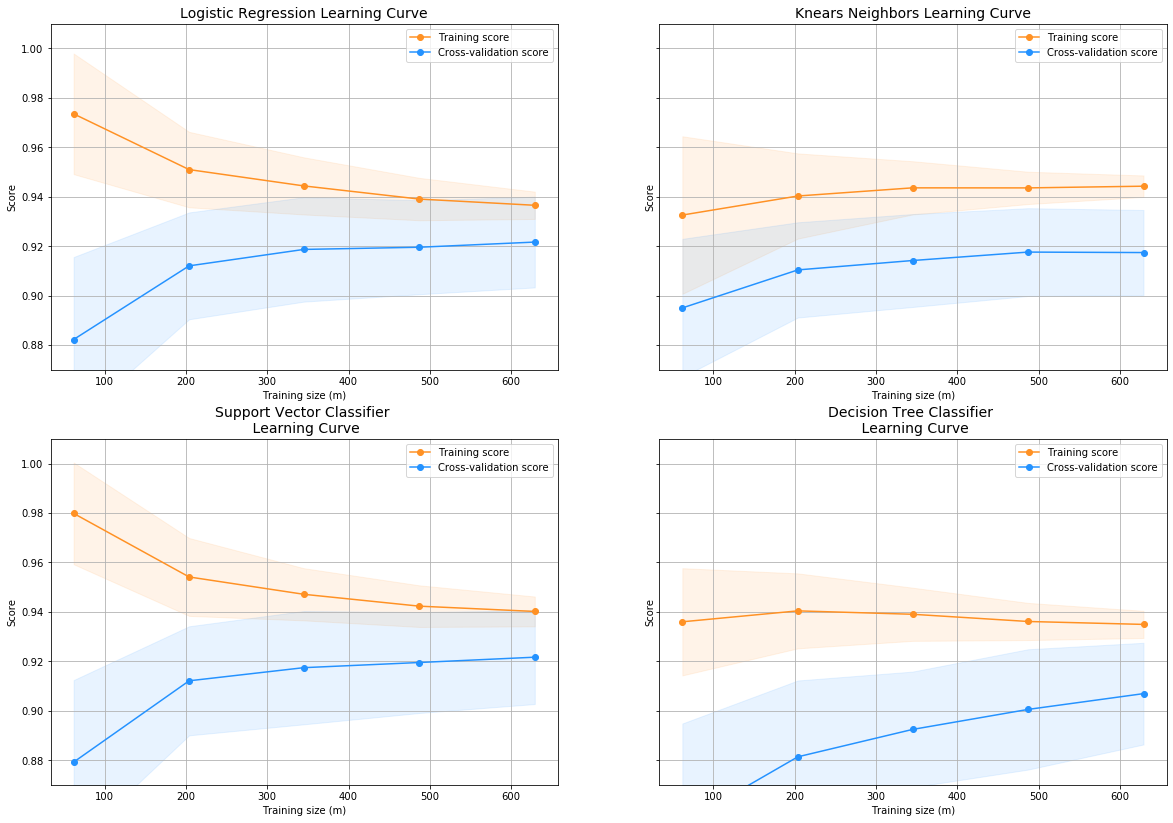

In [28]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

model.plot_learning_curve(
    estimator1=classifiers["Logistic Regression"],
    estimator2=classifiers["KNN"],
    estimator3=classifiers["Support Vector Machine"],
    estimator4=classifiers["Decision Tree Algorithm"],
    X=X_train,
    y=Y_train,
    ylim=(0.87, 1.01),
    cv=cv,
    n_jobs=4,
    train_sizes=np.linspace(.1, 1.0, 5)
)


Therefore we observe that KNN is a bit overfitted then the other models and Logistic Regression performs the best.

<h1> l. ROC_AUC_SCORE </h1>

In [29]:
model.roc_score(classifiers,X=X_train,Y=Y_train,cv=5,method='predict')

Logistic Regression:  0.9251323947300439
KNears Neighbors:  0.9137012399896667
Support Vector Classifier:  0.926398217514854
Decision Tree Classifier:  0.9150445621286489


<h1> m. Saving Training data and Testing data </h1>

In [30]:
# Save Training and Testing data in pickle for Future Use
model.pickleData(filename="X_train.pickle",data=X_train)
model.pickleData(filename="X_test.pickle",data=X_test)